In [1]:
import json
from PIL import Image, ImageDraw, ImageColor, ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
types = ["Web View", "List Item", "Multi-Tab", "Input", "Text Button", "Slider", "Background Image", "Advertisement", "Card", "Bottom Navigation", 
         "Modal", "On/Off Switch", "Button Bar", "Number Stepper", "Text", "Map View", "Checkbox", "Date Picker", "Image", "Drawer", "Radio Button", 
         "Video", "Toolbar", "Pager Indicator", "Icon", "Layout"]
group_types = ["Card", "Bottom Navigation", "Toolbar", "Layout", "Multi-Tab", "List Item", "Button Bar", "Modal", "On/Off Switch", "Drawer", "Image"]
MAX_X = 1440
MAX_Y = 2392
rico_path = "../../rico/"
hierarchy_path = rico_path + "hierarchies/"
img_path = rico_path + "unique_uis/combined/"

# Utils

In [3]:
def reduce_json(dic, new_dic):
    new_dic["children"] = []
    for child in dic["children"]:
        if child.get("componentLabel") is not None:
            label = child["componentLabel"]
            if label != "Advertisement" and label != "Map View" and label != "Background Image":# and label != "Image":
                rid = ""
                if child.get("resource-id") is not None:
                    rid = child["resource-id"]
                text = ""
                if child.get("text") is not None:
                    text = child["text"]
                new_child = {"id": rid, "type": label, "bounds": child["bounds"], "text": text}
                if child.get("children") is not None:
                    reduce_json(child, new_child) 
                new_dic["children"].append(new_child)

In [4]:
def rectangles_overlap(R1, R2):
    x0_1, y0_1, x1_1, y1_1 = R1
    x0_2, y0_2, x1_2, y1_2 = R2
    return not (x1_1 <= x0_2 or x1_2 <= x0_1 or y1_1 <= y0_2 or y1_2 <= y0_1)

In [5]:
def check_overlaps(comps, new_comp):
    overlaps = []
    for comp in comps:
        if rectangles_overlap(new_comp["bounds"], comp["bounds"]):
            overlaps.append(comp)
    return overlaps

In [6]:
def crop_covered_rectangle(R1, R2):
    x0_1, y0_1, x1_1, y1_1 = R1
    x0_2, y0_2, x1_2, y1_2 = R2

    # Check if the top edge of R1 is covered by R2
    if y0_2 <= y0_1 < y1_2 and x0_2 <= x0_1 and x1_2 >= x1_1:
        y0_1 = y1_2
    
    # Check if the bottom edge of R1 is covered by R2
    if y0_2 < y1_1 <= y1_2 and x0_2 <= x0_1 and x1_2 >= x1_1:
        y1_1 = y0_2
    
    # Check if the left edge of R1 is covered by R2
    if x0_2 <= x0_1 < x1_2 and y0_2 <= y0_1 and y1_2 >= y1_1:
        x0_1 = x1_2
    
    # Check if the right edge of R1 is covered by R2
    if x0_2 < x1_1 <= x1_2 and y0_2 <= y0_1 and y1_2 >= y1_1:
        x1_1 = x0_2
    
    # Check if any dimension of R1 has collapsed
    if x0_1 >= x1_1 or y0_1 >= y1_1:
        return None  # R1 is completely covered by R2
    
    return [x0_1, y0_1, x1_1, y1_1]

In [7]:
def is_inside(bounds2, bounds1):
    #print(bounds2, bounds1)
    if bounds2[0] >= bounds1[0]:
        if bounds2[2] <= bounds1[2]:
            if bounds2[1] >= bounds1[1]:
                if bounds2[3] <= bounds1[3]:
                    return True
    return False

In [8]:
def check_for_overlaps_and_crop(comps, new_comp):
    overlaps = check_overlaps(comps, new_comp)
    for comp in overlaps:
        new_comp["bounds"] = crop_covered_rectangle(new_comp["bounds"], comp["bounds"])
        if new_comp["bounds"] is None:
            break

In [9]:
def check_out_of_bounds_and_crop(new_comp):
    bounds = new_comp["bounds"]
    if bounds[0] < 0: 
        bounds[0] = 0
    if bounds[0] > MAX_X:
        return None
        
    if bounds[1] < 0:
        bounds[1] = 0
    if bounds[1] > MAX_Y:
        return None
        
    if bounds[2] > MAX_X:
        bounds[2] = MAX_X

    if bounds[3] > MAX_Y:
        bounds[3] = MAX_Y

    return bounds

In [10]:
def recurse_and_get_comps(dic):
    extracted_comps = []
    extracted_groups = []
    group_id_counter = 0
    comp_id_counter = 0

    def recurse(child, current_top_parent=None):
        indent = ""
        if current_top_parent is not None:
            indent = "   "
        nonlocal group_id_counter, comp_id_counter
        current_id = group_id_counter + comp_id_counter
        full_comps = [*extracted_comps, *extracted_groups]
        child["bounds"] = check_out_of_bounds_and_crop(child)
        if child["bounds"] is None:
            return

        is_top_parent = False
        
        if child.get("children") is not None:
            check_for_overlaps_and_crop(full_comps, child)
            if child["bounds"] is None:
                return
            group_id_counter += 1
            if child["type"] in group_types:
                
                new_parent = {"id": current_id, 
                              "type": child["type"], 
                              "bounds": child["bounds"], 
                              "ui_comp_ids": [], 
                              "ui_comp_group_ids": []}
                is_top_parent = True
                for subchild in child["children"]:
                    recurse(subchild, current_top_parent=new_parent)
                if not new_parent in extracted_groups:
                    extracted_groups.append(new_parent)
                else:
                    print("DUPLICATE PARENT")
        
            if not is_top_parent:
                if child["bounds"] is None:
                    return
                for subchild in child["children"]:
                    recurse(subchild, current_top_parent=current_top_parent)
                                    
        if not is_top_parent:
            if child["bounds"] is None:
                return
            check_for_overlaps_and_crop(full_comps, child)
            if child["bounds"] is None:
                return
            
            new_child = {"id": current_id, 
                         "type": child["type"], 
                         "bounds": child["bounds"]}
            if not new_child in extracted_comps:
                comp_id_counter += 1
                extracted_comps.append(new_child)
                if current_top_parent is not None:
                    current_top_parent["ui_comp_ids"].append(current_id)
            else:
                print(indent, "DUPLICATE CHILD")

    for child in dic["children"]:
        recurse(child)

    to_remove = []
    for group in extracted_groups:
        if len(group["ui_comp_ids"]) <= 0:
            to_remove.append(group)

    for remove in to_remove:
        extracted_groups.remove(remove)
    
    return extracted_comps, extracted_groups

In [11]:
def convert(comps, groups):
    gui = {"ui_comps": [], "ui_comp_groups": groups, "ungrouped_comps": []}
    for comp in comps:
        in_group = False
        for group in groups:
            if comp["id"] in group["ui_comp_ids"]:
                in_group = True
                break
        if in_group:
            gui["ui_comps"].append(comp)
        else:
            gui["ungrouped_comps"].append(comp)
    return gui

In [12]:
def find_elem(list, id, list2=None):
    for elem in list:
        if elem["id"]==id:
            return elem
    for elem in list2:
        if elem["id"]==id:
            return elem

In [13]:
def check_groups_inside(gui):
    groups = gui["ui_comp_groups"]
    groups = list(sorted(groups, key=lambda x: (x["bounds"][2] - x["bounds"][0]) * (x["bounds"][1] - x["bounds"][3])))

    to_remove = []
    for i in range(len(groups)):
        group_1 = groups[i]
        for j in range(i+1, len(groups)):
            group_2 = groups[j]
            if not group_2 in to_remove:
                if is_inside(group_2["bounds"], group_1["bounds"]):
                    for comp_id in group_2["ui_comp_ids"]:
                        group_1["ui_comp_ids"].append(comp_id)
                    to_remove.append(group_2)

    for remove in to_remove:
        gui["ui_comp_groups"].remove(remove)

In [14]:
def calculate_empty_spaces_width(rectangles):
    # Fixed grid size
    width = 1440
    height = 2392

    # Initialize the grid using numpy for faster operations
    grid = np.zeros((height, width), dtype=bool)

    # Mark the grid cells covered by rectangles
    for r in rectangles:
        grid[r[1]:r[3], r[0]:r[2]] = True

    # Collect all unique y boundaries
    y_coords = set([0, height])
    for r in rectangles:
        y_coords.update([r[1], r[3]])

    # Sort the y coordinates to define horizontal segments
    y_coords = sorted(y_coords)

    # Find empty spaces
    empty_rectangles = []

    # Traverse the grid by horizontal segments defined by the y coordinates
    for i in range(len(y_coords) - 1):
        y0, y1 = y_coords[i], y_coords[i + 1]

        # Within each horizontal segment, find vertical empty regions
        x_start = 0
        for r in sorted(rectangles, key=lambda x: x[0]):
            if r[1] <= y0 < r[3] or r[1] < y1 <= r[3]:  # Rectangle overlaps the horizontal segment
                x_end = r[0]
                if x_start < x_end:
                    empty_rectangles.append([x_start, y0, x_end, y1])
                x_start = r[2]
        if x_start < width:
            empty_rectangles.append([x_start, y0, width, y1])

    return empty_rectangles

# Example usage
rectangles = [
    [56, 554, 172, 670],
    [207, 554, 323, 670]
]

empty_spaces = calculate_empty_spaces_width(rectangles)
print("Empty spaces:", empty_spaces)


Empty spaces: [[0, 0, 1440, 554], [0, 554, 56, 670], [172, 554, 207, 670], [323, 554, 1440, 670], [0, 670, 1440, 2392]]


In [15]:
def calculate_empty_spaces_height(rectangles):
    # Fixed grid size
    width = 1440
    height = 2392

    # Initialize the grid using numpy for faster operations
    grid = np.zeros((height, width), dtype=bool)

    # Mark the grid cells covered by rectangles
    for r in rectangles:
        grid[r[1]:r[3], r[0]:r[2]] = True

    # Collect all unique x and y boundaries
    x_coords = set([0, width])
    y_coords = set([0, height])
    for r in rectangles:
        x_coords.update([r[0], r[2]])
        y_coords.update([r[1], r[3]])

    # Sort the coordinates to define regions
    x_coords = sorted(x_coords)
    y_coords = sorted(y_coords)

    # Find empty spaces
    empty_rectangles = []

    # Traverse the grid by regions defined by the coordinates
    for i in range(len(x_coords) - 1):
        x0, x1 = x_coords[i], x_coords[i + 1]
        vertical_empty_ranges = []
        current_empty_range_start = None

        for j in range(len(y_coords) - 1):
            y0, y1 = y_coords[j], y_coords[j + 1]
            # Check if the current region is empty
            if not grid[y0:y1, x0:x1].any():
                if current_empty_range_start is None:
                    current_empty_range_start = y0
            else:
                if current_empty_range_start is not None:
                    vertical_empty_ranges.append((current_empty_range_start, y0))
                    current_empty_range_start = None

        if current_empty_range_start is not None:
            vertical_empty_ranges.append((current_empty_range_start, height))

        for y0, y1 in vertical_empty_ranges:
            empty_rectangles.append([x0, y0, x1, y1])

    return empty_rectangles

# Example usage
rectangles = [
    [56, 554, 172, 670],
    [207, 554, 323, 670]
]

empty_spaces = calculate_empty_spaces_height(rectangles)
print("Empty spaces:", empty_spaces)


Empty spaces: [[0, 0, 56, 2392], [56, 0, 172, 554], [56, 670, 172, 2392], [172, 0, 207, 2392], [207, 0, 323, 554], [207, 670, 323, 2392], [323, 0, 1440, 2392]]


In [16]:
def check_ungroupeds_inside(gui):
    comps = gui["ui_comps"]
    groups = gui["ui_comp_groups"]
    ungroupeds = gui["ungrouped_comps"]

    for group in groups:
        to_remove = []
        bounds = group["bounds"]
        for comp in ungroupeds:
            if is_inside(comp["bounds"], bounds):
                group["ui_comp_ids"].append(comp["id"])
                to_remove.append(comp)
        if len(to_remove) > 0:
            for remove in to_remove:
                ungroupeds.remove(remove)
                comps.append(remove)

    ungroupeds = list(sorted(ungroupeds, key=lambda x: (x["bounds"][2] - x["bounds"][0]) * (x["bounds"][1] - x["bounds"][3])))
    to_remove_group = []
    to_remove_comp = []
    for i in range(len(ungroupeds)):
        u_1 = ungroupeds[i]
        new_group = {"id": u_1["id"], 
                     "type": u_1["type"], 
                     "bounds": u_1["bounds"], 
                     "ui_comp_ids": [], 
                     "ui_comp_group_ids": []}
        
        for j in range(i+1, len(ungroupeds)):
            u_2 = ungroupeds[j]
            if not u_2 in to_remove_comp:
                if is_inside(u_2["bounds"], u_1["bounds"]):
                    new_group["ui_comp_ids"].append(u_2["id"])
                    to_remove_comp.append(u_2)
                    
        if len(new_group["ui_comp_ids"]) > 0:
            groups.append(new_group)
            to_remove_group.append(u_1)

    for r in to_remove_group:
        gui["ungrouped_comps"].remove(r)

    for r in to_remove_comp:
        gui["ungrouped_comps"].remove(r)
        comps.append(r)


In [17]:
def group_ungrouped_comps(gui):
    max_id = 0
    comps = gui["ui_comps"]
    groups = gui["ui_comp_groups"]
    ungroupeds = gui["ungrouped_comps"]
    for c in comps:
        if max_id < c["id"]:
            max_id = c["id"]
    for c in groups:
        if max_id < c["id"]:
            max_id = c["id"]
    for c in ungroupeds:
        if max_id < c["id"]:
            max_id = c["id"]

    rectangles = []
    for group in groups:
        rectangles.append(group["bounds"])
    empty_spaces = calculate_empty_spaces_width(rectangles)
    current_id = max_id+1
    for empty in empty_spaces:
        to_remove = []
        new_group = {"id": current_id, 
                     "type": "ungrouped", 
                     "bounds": empty, 
                     "ui_comp_ids": [], 
                     "ui_comp_group_ids": []}
        for comp in ungroupeds:
            if is_inside(comp["bounds"], empty):
                new_group["ui_comp_ids"].append(comp["id"])
                to_remove.append(comp)
        if len(to_remove) > 0:
            groups.append(new_group)
            current_id += 1
            for remove in to_remove:
                ungroupeds.remove(remove)
                comps.append(remove)

    if len(ungroupeds) > 0:
        rectangles = []
        for group in groups:
            rectangles.append(group["bounds"])
        empty_spaces = calculate_empty_spaces_height(rectangles)
        current_id = max_id+1
        for empty in empty_spaces:
            to_remove = []
            new_group = {"id": current_id, 
                         "type": "ungrouped", 
                         "bounds": empty, 
                         "ui_comp_ids": [], 
                         "ui_comp_group_ids": []}
            for comp in ungroupeds:
                if is_inside(comp["bounds"], empty):
                    new_group["ui_comp_ids"].append(comp["id"])
                    to_remove.append(comp)
            if len(to_remove) > 0:
                groups.append(new_group)
                current_id += 1
                for remove in to_remove:
                    ungroupeds.remove(remove)
                    comps.append(remove)
        

In [18]:
def draw_on_image(gui, img, empty_spaces = []):
    comps = gui["ui_comps"]
    groups = gui["ui_comp_groups"]
    ungroupeds = gui["ungrouped_comps"]
    draw = ImageDraw.Draw(img)
    ratio = float(img.width)/1440
    for comp in comps: 
        bounds = comp["bounds"]
        x0 = bounds[0] * ratio
        y0 = bounds[1] * ratio
        x1 = bounds[2] * ratio
        y1 = bounds[3] * ratio
        draw.rectangle([x0, y0, x1, y1], outline = "#ff000055", width = 4)
        draw.text([x0, y0], str(comp["id"]), font_size=30, fill="#ff000055")
    
    for group in groups: 
        bounds = group["bounds"]
        x0 = bounds[0] * ratio
        y0 = bounds[1] * ratio
        x1 = bounds[2] * ratio
        y1 = bounds[3] * ratio
        draw.rectangle([x0, y0, x1, y1], outline = "#00ff0055", width = 4)
        draw.text([x0, y0], str(group["id"]), font_size=30, fill="#00ff0055")

    for comp in ungroupeds:
        bounds = comp["bounds"]
        x0 = bounds[0] * ratio
        y0 = bounds[1] * ratio
        x1 = bounds[2] * ratio
        y1 = bounds[3] * ratio
        draw.rectangle([x0, y0, x1, y1], outline = "#40E0D055", width = 4)
        draw.text([x0, y0], str(comp["id"]), font_size=30, fill="#40E0D055")

    for bounds in empty_spaces:
        x0 = bounds[0] * ratio
        y0 = bounds[1] * ratio
        x1 = bounds[2] * ratio
        y1 = bounds[3] * ratio
        draw.rectangle([x0, y0, x1, y1], outline = "#00000000", width = 4)

# Metrics

In [19]:
def elem_smallness(gui):
    group_infos = []
    ui_comps = gui["ui_comps"]
    ungrouped_comps = gui["ungrouped_comps"]
    groups = gui["ui_comp_groups"]
    measured_comps = []
    for group in groups:
        if group["id"] != -1:
            widths = []
            heights = []
            group_bounds = group["bounds"]
            group_width = abs(group_bounds[0] - group_bounds[2])
            group_height = abs(group_bounds[1] - group_bounds[3])
            group_area = group_width*group_height
            comp_ids = group["ui_comp_ids"]
            for id in comp_ids:
                elem = find_elem(ui_comps, id, groups)
                bounds = elem["bounds"]
                width = abs(bounds[0] - bounds[2])
                height = abs(bounds[1] - bounds[3])
                if not (group_width == width and group_height == height):
                    widths.append(width)
                    heights.append(height)
                measured_comps.append(id)
            mean_width = np.mean(np.array(widths))
            mean_height = np.mean(np.array(heights))
            group_infos.append({"id": group["id"], "area": group_area, "mean_height": mean_height, "mean_width": mean_width})
    for comp in ungrouped_comps:
        if comp["id"] not in measured_comps:# and comp["clickable"] == True:
            bounds = comp["bounds"]
            width = abs(bounds[0] - bounds[2])
            height = abs(bounds[1] - bounds[3])
            area = width*height
            measured_comps.append(comp["id"])
            group_infos.append({"id": comp["id"], "area": area, "mean_height": height, "mean_width": width})
    width_strich = 0
    height_strich = 0
    area_strich = 0
    for group in group_infos:
        if not np.isnan(group["mean_width"]) and not np.isnan(group["mean_height"]):
            area_strich += group["area"]
            width_strich += group["area"] * group["mean_width"]
            height_strich += group["area"] * group["mean_height"]
    if area_strich == 0:
        area_strich = MAX_X*MAX_Y
    width_strich = 1/area_strich*width_strich
    height_strich = 1/area_strich*height_strich
    if width_strich != 0 and height_strich != 0:
        smallness = ((1 - width_strich/MAX_X) + (1 - height_strich/MAX_Y))/2
    else:
        smallness = 0
    return smallness

In [30]:
def find_neighbors(comp, comps):
    rights = [{"id": "", "bounds": "", "dist": 2000}]
    bots = [{"id": "", "bounds": "", "dist": 2000}]
    bounds = comp["bounds"]
    for other_comp in comps:
        if other_comp != comp:
            bounds2 = other_comp["bounds"]
            if lines_up_hor(bounds, bounds2):
                dist = bounds2[2] - bounds[2]
                if dist >= 0 or rectangles_overlap(bounds, bounds2):
                    if dist < rights[0]["dist"]:
                        rights = [{"id": "", "bounds": "", "dist": 2000}]
                        rights[0]["id"] = other_comp["id"]
                        rights[0]["bounds"] = other_comp["bounds"]
                        rights[0]["dist"] = dist
                    elif dist == rights[0]["dist"]:
                        new_right = {"id": other_comp["id"], "bounds": other_comp["bounds"], "dist": dist}
                        rights.append(new_right)
                        
            if lines_up_vert(bounds, bounds2):
                dist = bounds2[3] - bounds[3]
                if dist >= 0 or rectangles_overlap(bounds, bounds2):
                    if dist < bots[0]["dist"]:
                        bots = [{"id": "", "bounds": "", "dist": 2000}]
                        bots[0]["id"] = other_comp["id"]
                        bots[0]["bounds"] = other_comp["bounds"]
                        bots[0]["dist"] = dist
                    elif dist == bots[0]["dist"]:
                        new_bot = {"id": other_comp["id"], "bounds": other_comp["bounds"], "dist": dist}
                        bots.append(new_bot)
                    
    return rights, bots

def alignment(gui):
    group_infos = []
    ui_comps = gui["ui_comps"]
    ungrouped_comps = gui["ungrouped_comps"]
    groups = gui["ui_comp_groups"]
    for group in groups:
        if len(group["ui_comp_group_ids"]) == 0:
            hor_alignments = 0
            vert_alignments = 0
            cent_alignments = 0
            poss_alignments = 0
            group_bounds = group["bounds"]
            group_width = abs(group_bounds[0] - group_bounds[2])
            group_height = abs(group_bounds[1] - group_bounds[3])
            group_area = group_width*group_height
            comp_ids = group["ui_comp_ids"]
            grp_comps = []
            for id in comp_ids:
                grp_comps.append(find_elem(ui_comps, id))
            grp_comps = list(sorted(grp_comps, key=lambda x: (x["bounds"][0], x["bounds"][1])))
            for comp in grp_comps:
                rights, bots = find_neighbors(comp, grp_comps)
                for right in rights:
                    if right["id"] != "":
                        poss_alignments += 2
                        if right["bounds"][1] == comp["bounds"][1] or right["bounds"][3] == comp["bounds"][3]:
                            vert_alignments += 1
                        if np.round((right["bounds"][1] + right["bounds"][3])/2) - np.round((comp["bounds"][1] + comp["bounds"][3])/2) <= 2:
                            cent_alignments += 1
                for bot in bots:
                    if bot["id"] != "":
                        poss_alignments += 2
                        if bot["bounds"][0] == comp["bounds"][0] or bot["bounds"][2] == comp["bounds"][2]:
                            hor_alignments += 1
                        if np.round((bot["bounds"][0] + bot["bounds"][2])/2) - np.round((comp["bounds"][0] + comp["bounds"][2])/2) <= 2:
                            cent_alignments += 1

            group_infos.append({"id": group["id"], "area": group_area, "hor_alignments": hor_alignments, "vert_alignments": vert_alignments,
                                "cent_alignments": cent_alignments, "poss_alignments": poss_alignments})
    hor_alignments_strich = 0
    vert_alignments_strich = 0
    cent_alignments_strich = 0
    area_strich = 0
    total_poss_alignments = 0
    for group in group_infos:
        if group["poss_alignments"] != 0 and group["area"] != 0:
            area_strich += group["area"]
            total_poss_alignments += group["poss_alignments"]
            hor_alignments_strich += (group["area"] * (group["hor_alignments"]/group["poss_alignments"]))
            vert_alignments_strich += (group["area"] * (group["vert_alignments"]/group["poss_alignments"]))
            cent_alignments_strich += (group["area"] * (group["cent_alignments"]/group["poss_alignments"]))
    if area_strich == 0:
        area_strich = MAX_X*MAX_X
    hor_alignments_strich = 1/area_strich*hor_alignments_strich
    vert_alignments_strich = 1/area_strich*vert_alignments_strich
    cent_alignments_strich = 1/area_strich*cent_alignments_strich
    if total_poss_alignments != 0:
        M = 1 - (hor_alignments_strich + vert_alignments_strich + cent_alignments_strich)
    else:
        M = 0
    return M

In [23]:
def density(gui):
    standard_total_area = MAX_X*MAX_Y
    areas = 0
    total_area = 0
    measured_comps = []
    ui_comps = gui["ui_comps"]
    ungrouped_comps = gui["ungrouped_comps"]
    groups = gui["ui_comp_groups"]
    for group in groups:
        group_bounds = group["bounds"]
        group_width = abs(group_bounds[0] - group_bounds[2])
        group_height = abs(group_bounds[1] - group_bounds[3])
        group_area = group_width*group_height
        total_area += group_area
    for u_comp in ungrouped_comps:
        u_comp_bounds = u_comp["bounds"]
        u_comp_width = abs(u_comp_bounds[0] - u_comp_bounds[2])
        u_comp_height = abs(u_comp_bounds[1] - u_comp_bounds[3])
        u_comp_area = u_comp_width*u_comp_height
        areas += u_comp_area
        total_area += u_comp_area
    for comp in ui_comps:
        comp_bounds = comp["bounds"]
        comp_width = abs(comp_bounds[0] - comp_bounds[2])
        comp_height = abs(comp_bounds[1] - comp_bounds[3])
        comp_area = comp_width*comp_height
        areas += comp_area
    if total_area < standard_total_area:
        total_area = standard_total_area
    D = 1/total_area*areas
    return D

In [24]:
def lines_up_vert(bounds1, bounds2):
    if bounds1[0] < bounds2[2] and bounds1[2] > bounds2[0]:
        return True
    return False
            
def lines_up_hor(bounds1, bounds2):
    if bounds1[1] < bounds2[3] and bounds1[3] > bounds2[1]:
        return True
    return False

In [25]:
print(lines_up_hor([92, 316, 1348, 484], [92, 484, 1348, 652]))
print(lines_up_hor([92, 484, 1348, 652], [92, 316, 1348, 484]))
print(lines_up_hor([1082, 2154, 1306, 2322], [811, 2154, 1082, 2322]))

False
False
True


In [26]:
def imbalance(gui):
    ui_comps = gui["ui_comps"]
    groups = gui["ui_comp_groups"]
    group_infos = []
    for group in groups:
        if len(group["ui_comp_ids"]) < 1:
           continue 
        group_bounds = group["bounds"]
        group_width = abs(group_bounds[0] - group_bounds[2])
        group_height = abs(group_bounds[1] - group_bounds[3])
        group_area = group_width*group_height
        sub_bounds = [(group["id"], group_bounds)]
        comp_ids = group["ui_comp_ids"]
        for id in comp_ids:
            elem = find_elem(ui_comps, id, groups)
            bounds = elem["bounds"]
            sub_bounds.append((id,bounds))
        sorted_bounds = sorted(sub_bounds, key=lambda x: x[1][0])
        hor_margins = []
        vert_margins = []
        for id, bounds in sorted_bounds:
            if id == group["id"]:
                continue
            else:
                nearest_left = bounds[0] - sorted(sub_bounds, key=lambda x: bounds[0] - x[1][2] if\
                                                  lines_up_hor(bounds, x[1]) and bounds[0] >= x[1][2] else 3000)[0][1][2]
                if nearest_left < 0:
                    nearest_left = bounds[0] -\
                    sorted(sub_bounds, key=lambda x: bounds[0] - x[1][0] if\
                           lines_up_hor(bounds, x[1]) and bounds[0] >= x[1][0] and x[0] != id else 3000)[0][1][0]
                
                nearest_right = sorted(sub_bounds, key=lambda x: x[1][0] - bounds[2] if\
                                       lines_up_hor(bounds, x[1]) and x[1][0] >= bounds[2] else 3000)[0][1][0] - bounds[2]
                if nearest_right < 0:
                    nearest_right = sorted(sub_bounds, key=lambda x: x[1][2] - bounds[2] if\
                                           lines_up_hor(bounds, x[1]) and x[1][2] >= bounds[2] and x[0] != id else 3000)[0][1][2] -\
                    bounds[2]

                nearest_top = bounds[1] - sorted(sub_bounds, key=lambda x: bounds[1] - x[1][3] if\
                                                 lines_up_vert(bounds, x[1]) and bounds[1] >= x[1][3] else 3000)[0][1][3]
                if nearest_top < 0:
                    nearest_top = bounds[1] - \
                    sorted(sub_bounds, key=lambda x: bounds[1] - x[1][1] if\
                           lines_up_vert(bounds, x[1]) and bounds[1] >= x[1][1] and x[0] != id else 3000)[0][1][1]

                nearest_bot = sorted(sub_bounds, key=lambda x: x[1][1] - bounds[3] if\
                                     lines_up_vert(bounds, x[1]) and x[1][1] >= bounds[3] else 3000)[0][1][1] - bounds[3]
                if nearest_bot < 0:
                    nearest_bot = sorted(sub_bounds, key=lambda x: x[1][3] - bounds[3] if\
                                         lines_up_vert(bounds, x[1]) and x[1][3] >= bounds[3] and x[0] != id else 3000)[0][1][3] -\
                    bounds[3]
                hor_margins.append(nearest_left)
                hor_margins.append(nearest_right)
                vert_margins.append(nearest_top)
                vert_margins.append(nearest_bot)
        
        hor_margins = np.array(hor_margins)
        vert_margins = np.array(vert_margins)
        max_hor_marg = np.max(hor_margins)
        max_vert_marg = np.max(vert_margins)
        balh = 0
        if max_hor_marg != 0:
            i = 0
            total_hor_margs = 0
            while i+1 < len(hor_margins):
                total_hor_margs += hor_margins[i] + hor_margins[i+1]
                i += 2
            avg_hor_marg = 1/len(comp_ids)*total_hor_margs
            balh = avg_hor_marg/(2*max_hor_marg)
        else:
            balh = 1
        balv = 0
        if max_vert_marg != 0:
            i = 0
            total_vert_margs = 0
            while i+1 < len(vert_margins):
                total_vert_margs += vert_margins[i] + vert_margins[i+1]
                i += 2
            avg_vert_marg = 1/len(comp_ids)*total_vert_margs
            balv = avg_vert_marg/(2*max_vert_marg)
        else:
            balv = 1
        group_infos.append({"id": group["id"], "area": group_area, "balh": balh, "balv": balv})

    if len(group_infos) > 0:
        balh_strich = 0
        balv_strich = 0
        area_strich = 0
        for group in group_infos:
            if group["area"] != 0:
                area_strich += group["area"]
                balh_strich += group["area"]*group["balh"]
                balv_strich += group["area"]*group["balv"]
        if area_strich == 0:
            area_strich = MAX_X*MAX_Y
        balh_strich = 1/area_strich * balh_strich
        balv_strich = 1/area_strich * balv_strich
        B = 1 - (balh_strich + balv_strich)/2
    else:
        B = 0
    return B

In [27]:
def count_elems(gui):
    count = len(gui["ungrouped_comps"])
    for group in gui["ui_comp_groups"]:
        count += len(group["ui_comp_ids"])
    return count

# Stats

In [28]:
all_guis = pd.read_csv("../../rico/all_guis.csv").set_index("id")
all_guis.rename(columns={"id":"screen_id"}, inplace=True)

In [29]:
design_topics = pd.read_csv(rico_path + "design_topics.csv").set_index("screen_id")
design_topics.drop(design_topics[design_topics["topic"]=="tutorial"].index, inplace=True)
design_topics.drop(design_topics[design_topics["topic"]=="menu"].index, inplace=True)
design_topics.drop(design_topics[design_topics["topic"]=="modal"].index, inplace=True)
issues = pd.read_csv(rico_path + "issues.csv")
for index, row in issues.iterrows():
    try:
        design_topics.drop(row["screen_id"], inplace=True)
    except:
        continue
to_drop = []
for index, row in design_topics.iterrows():
    if index not in list(all_guis.index):
        to_drop.append(index)
design_topics.drop(to_drop, inplace=True)

print(len(design_topics))
design_topics.head()

952


,topic
screen_id,
320,list
39729,login
8555,form
38398,other
66542,form


In [31]:
data = []
for id, row in design_topics.iterrows():
    number = str(id)
    print(number)
    try:
        dic = json.load(open(hierarchy_path + number + ".json", "r"))
    except:
        dic = json.load(open(hierarchy_path + number + ".json", "r", encoding="utf-8"))
    img = Image.open(img_path + number + ".jpg")
    
    new_dic = {}
    reduce_json(dic, new_dic)
    new_row = {"screen": number, "smallness": 0, "misalignment": 0, "imbalance": 0, "density": 0, "elems": 0, "groups": 0}
    
    comps, groups = recurse_and_get_comps(new_dic)
    gui = convert(comps, groups)
    
    check_groups_inside(gui)
    check_ungroupeds_inside(gui)
    group_ungrouped_comps(gui)
    
    if len(gui["ui_comp_groups"]) >= 1 and len(gui["ungrouped_comps"]) <= 1 and count_elems(gui) >= 3:# and new_density(gui) < 1:
        new_row["smallness"] = elem_smallness(gui)
        new_row["misalignment"] = alignment(gui)
        new_row["imbalance"] = imbalance(gui)
        new_row["density"] = density(gui)
        new_row["elems"] = count_elems(gui)
        new_row["groups"] = len(gui["ui_comp_groups"])
        new_row["ungroupeds"] = len(gui["ungrouped_comps"])
        data.append(new_row)
        
data_df = pd.DataFrame(data)
data_df.head()

320
39729
8555
38398
66542
50721
68970
39647
7953
19574
49936
18942
12675
24965
34389
58072
546
25075
18483
43086
26246
8659
8613
6013
38792
46814
9828
17135
70174
38968
295
46762
58115
70500
1068
54880
53381
65584
9735


C:\Users\thoma\anaconda3\envs\MAtest\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\thoma\anaconda3\envs\MAtest\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


68347
70950
46705
19342
69913
31104
28535
13575
30518
62160
65183
53368
22481
13648
5459
21833
15950
46309
21780
11235
59116
68871
58984
34344
39241
2317
55312
26721
52193
18869
64480
52760
16254
55287
27885
60556
40110
7902
30006
38404
36126
40726
16741
62105
52855
49197
30368
6713
8875
8592
66615
61612
42549
32731
24384
33407
52842
38393
35341
3923
5915
21230
55479
30259
66033
71317
30626
41981
41976
34509
41174
63555
67146
23167
34351
62142
68088
67717
71431
56330
39118
7726
58500
39223
61678
34952
18587
13420
15674
37078
9910
65875
56159
39125
62368
41728
2858
47708
47423
52107
47705
8209
48515
11658
62095
44118
59417
39015
50074
60834
56890
38679
10592
50978
14143
47319
57946
42468
64013
33485
65887
50028
50395
13705
12954
32366
16347
30856
6608
19117
37266
7198
5148
5944
25022
33932
67565
35424
42992
21413
16342
54869
36917
12833
15574
45134
19337
1371
2834
31445
62601
22082
41292
29668
57841
21956
59455
60315
69818
35591
56017
48910
37922
28292
28164
21103
21981
48236
14554
4938

,screen,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
0,320,0.870295,0.551607,0.468174,0.256677,40,13,0
1,39729,0.608725,0.400000,0.732824,0.233798,6,1,0
2,8555,0.677320,0.444444,0.822404,0.277475,9,1,0
3,38398,0.734543,0.435194,0.769676,0.463941,19,2,0
4,66542,0.658096,0.347487,0.787995,0.192275,6,2,0


In [32]:
data_df.describe()

,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,0.734495,0.376225,0.546083,0.417221,15.293798,4.275299,0.033732
std,0.112462,0.169852,0.212315,0.234277,10.291327,3.802211,0.180638
min,0.295736,0.000000,0.010727,0.025305,3.000000,1.000000,0.000000
25%,0.659448,0.271329,0.415253,0.222219,8.000000,2.000000,0.000000
50%,0.747984,0.414030,0.581350,0.377418,12.000000,3.000000,0.000000
75%,0.822852,0.500000,0.710857,0.606086,20.000000,6.000000,0.000000
max,0.969153,0.947761,0.924180,0.976465,74.000000,23.000000,1.000000


In [33]:
data_df.to_csv("../metric_statistics_enrico.csv", index=False)

In [34]:
data_df = pd.read_csv("../metric_statistics_enrico.csv")
data_df.describe()

,screen,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000
mean,35023.363439,0.734495,0.376225,0.546083,0.417221,15.293798,4.275299,0.033732
std,21088.091675,0.112462,0.169852,0.212315,0.234277,10.291327,3.802211,0.180638
min,124.000000,0.295736,0.000000,0.010727,0.025305,3.000000,1.000000,0.000000
25%,16327.000000,0.659448,0.271329,0.415253,0.222219,8.000000,2.000000,0.000000
50%,35342.000000,0.747984,0.414030,0.581350,0.377418,12.000000,3.000000,0.000000
75%,53062.000000,0.822852,0.500000,0.710857,0.606086,20.000000,6.000000,0.000000
max,72186.000000,0.969153,0.947761,0.924180,0.976465,74.000000,23.000000,1.000000


In [35]:
figma_df = pd.read_csv("../metric_statistics_figma.csv")
figma_df.head()

,screen,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
0,adoption_1,0.780597,0.389629,0.446537,0.537109,26,5,0
1,banking_1,0.768265,0.469341,0.549152,0.773777,47,6,0
2,banking_2,0.833683,0.240878,0.232389,0.362973,51,8,0
3,banking_3,0.686710,0.500000,0.835316,0.251933,15,2,0
4,banking_4,0.751270,0.389333,0.461853,0.136659,8,2,0


In [36]:
con_df = pd.concat([data_df[["screen", "smallness", "misalignment", "imbalance", "density", "elems", "groups", "ungroupeds"]], figma_df])
con_df.head()

,screen,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
0,320,0.870295,0.551607,0.468174,0.256677,40,13,0
1,39729,0.608725,0.400000,0.732824,0.233798,6,1,0
2,8555,0.677320,0.444444,0.822404,0.277475,9,1,0
3,38398,0.734543,0.435194,0.769676,0.463941,19,2,0
4,66542,0.658096,0.347487,0.787995,0.192275,6,2,0


In [37]:
con_df.describe()

,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
count,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.737229,0.371823,0.545336,0.419186,15.936853,4.347826,0.032091
std,0.111094,0.169155,0.210145,0.232492,10.719270,3.782031,0.176333
min,0.295736,0.000000,0.010727,0.025305,3.000000,1.000000,0.000000
25%,0.663807,0.266864,0.415733,0.227251,8.000000,2.000000,0.000000
50%,0.752305,0.406132,0.580301,0.382706,13.000000,3.000000,0.000000
75%,0.822890,0.500000,0.702479,0.607490,22.000000,6.000000,0.000000
max,0.969153,0.947761,0.924180,0.976465,74.000000,23.000000,1.000000


In [38]:
con_df.to_csv("../metrics_enrico_and_figma.csv")

In [174]:
con_df.sort_values(by="smallness", ascending=True).head(20)

,screen,smallness,misalignment,imbalance,density,elems,groups,ungroupeds
365,19293,0.295736,0.109626,0.287801,0.769520,7,3,0
394,63777,0.360091,0.500000,0.116937,0.905535,9,6,0
514,15393,0.384204,0.042461,0.326446,0.923958,5,2,0
386,26200,0.396113,0.064702,0.190035,0.852271,8,3,0
687,20147,0.411802,0.485846,0.529093,0.801473,6,2,0
374,70502,0.422171,0.042461,0.320584,0.501775,4,2,0
288,26442,0.440747,0.043730,0.366247,0.889955,7,3,0
882,19605,0.442591,0.000000,0.308424,0.957634,7,7,0
602,64608,0.445547,0.264049,0.335361,0.686567,11,4,1
42,19342,0.447147,0.083333,0.382723,0.781993,9,2,1


28132
GROUPS
{'id': 11, 'type': 'ungrouped', 'bounds': [0, 0, 1440, 2392], 'ui_comp_ids': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'ui_comp_group_ids': []}
COMPS
{'id': 0, 'type': 'Text', 'bounds': [70, 84, 1300, 186]}
{'id': 1, 'type': 'Text', 'bounds': [1402, 207, 1422, 254]}
{'id': 2, 'type': 'Text', 'bounds': [1402, 2327, 1422, 2374]}
{'id': 3, 'type': 'List Item', 'bounds': [1410, 272, 1414, 2309]}
{'id': 4, 'type': 'Text', 'bounds': [36, 200, 1384, 447]}
{'id': 5, 'type': 'Input', 'bounds': [39, 567, 185, 707]}
{'id': 6, 'type': 'Input', 'bounds': [185, 567, 331, 707]}
{'id': 7, 'type': 'Input', 'bounds': [331, 567, 477, 707]}
{'id': 8, 'type': 'Input', 'bounds': [477, 567, 623, 707]}
{'id': 9, 'type': 'Input', 'bounds': [623, 567, 769, 707]}
{'id': 10, 'type': 'Text Button', 'bounds': [18, 805, 1384, 1015]}
UNGROUPED

SMALLNESS 0.7866539559474341

MISALIGNMENT 0.631578947368421

IMBALANCE 0.9084721041449524

DENSITY 0.248950204384987

ELEMS 11


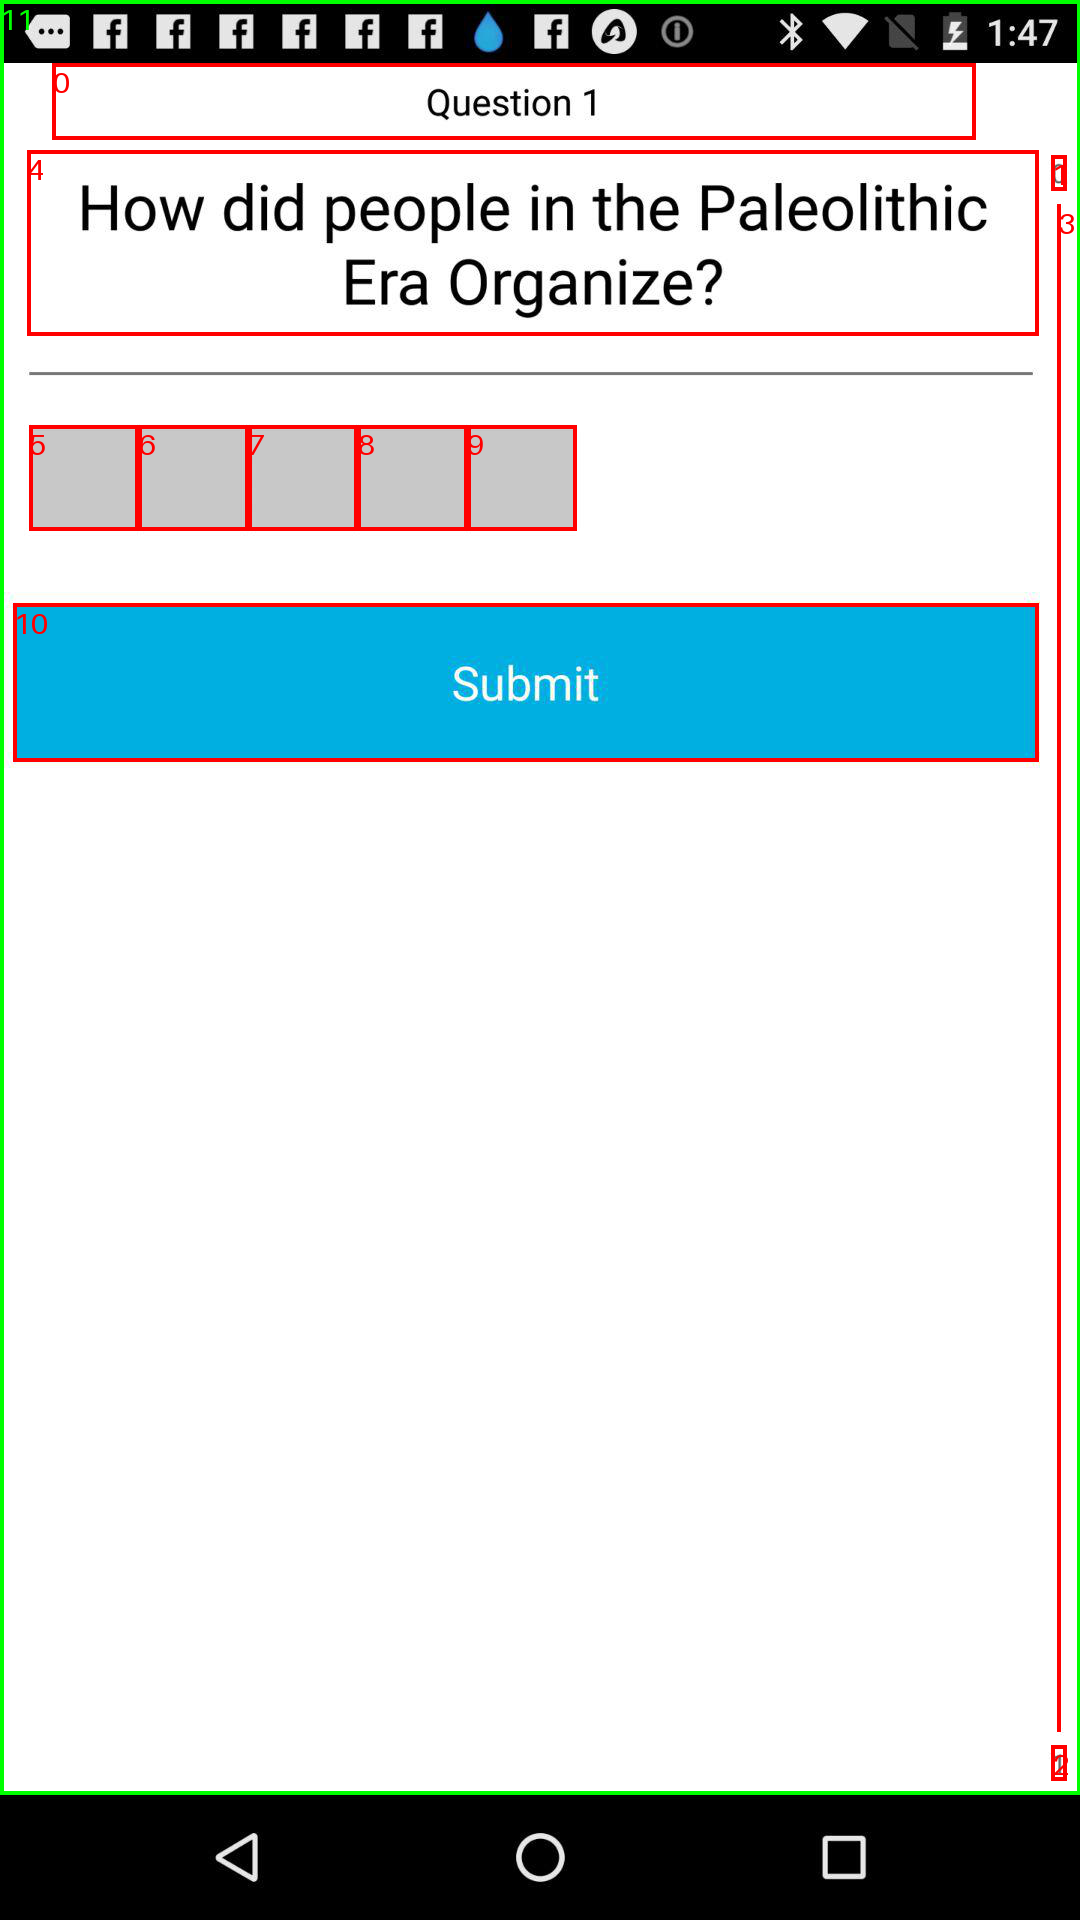

In [35]:
#number = str(data_df["screen"][random.sample(list(data_df.index), 1)[0]])
number = "28132"
print(number)
try:
    dic = json.load(open(hierarchy_path + number + ".json", "r"))
except:
    dic = json.load(open(hierarchy_path + number + ".json", "r", encoding="utf-8"))
img = Image.open(img_path + number + ".jpg")
new_dic = {}
reduce_json(dic, new_dic)


comps, groups = recurse_and_get_comps(new_dic)
gui = convert(comps, groups)

check_groups_inside(gui)
check_ungroupeds_inside(gui)
group_ungrouped_comps(gui)

print("GROUPS")
for c in gui["ui_comp_groups"]:
    print(c)
print("COMPS")
for c in gui["ui_comps"]:
    print(c)
print("UNGROUPED")
for c in gui["ungrouped_comps"]:
    print(c)
print()

smallness = elem_smallness(gui)
print("SMALLNESS", smallness)
print()
print("MISALIGNMENT", alignment(gui))
print()
print("IMBALANCE", imbalance(gui))
print()
print("DENSITY", density(gui))
print()
print("ELEMS", count_elems(gui))

rectangles = []
for group in groups:
    rectangles.append(group["bounds"])
#empty_spaces = calculate_empty_spaces_width(rectangles)

draw_on_image(gui, img)#, empty_spaces)
display(img)
#img.save("../density_high_ex_" + number + ".jpg")